<a href="https://colab.research.google.com/github/pesfahanian/MRNet_V1/blob/main/MRNet_axial_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%cd /content/drive/MyDrive/MRNet-v1.0

/content/drive/MyDrive/MRNet-v1.0


In [17]:
!ls

csv    train-abnormal.csv  valid	       valid_features
train  train_features	   valid-abnormal.csv


In [37]:
import glob
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import gray2rgb

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import keras_preprocessing
from keras.layers import Input
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.layers.core import Dense, Activation, Dropout
from keras.applications.densenet import DenseNet121

In [ ]:
IMG_SIZE = 256

In [ ]:
input_image = Input((IMG_SIZE, IMG_SIZE, 3))
feature_extractor = DenseNet121(include_top     =   False,
                                weights         =   'imagenet',
                                input_tensor    =   input_image, 
                                input_shape     =   (IMG_SIZE, IMG_SIZE, 3),
                                pooling         =   'avg')

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
feature_extractor.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# Do this later
def transform(s):
    s = s.astype("float32") / 255
    s[:, :, 0] = (s[:, :, 0] - 0.485) / 0.229
    s[:, :, 1] = (s[:, :, 1] - 0.456) / 0.224
    s[:, :, 2] = (s[:, :, 2] - 0.406) / 0.225
    return s

In [ ]:
# For all scans, so the following:
#   - For each slice in the scan, do the following:
#       - Read .npy of scan.
#       - Stack to make it 3D.
#       - Transform.
#       - Convert to Image.
#       - Put the image through the model.
#       - Append slice features to scan feature list
#   - Merge all slice features into one.
#   - Append the result to total feature list.  

In [ ]:
def extract_features(s):
    img = gray2rgb(s)
    img_t = transform(img)
    # IMAGE = Image.fromarray(img)
    batch = np.expand_dims(img_t, axis=0)
    f = feature_extractor.predict(batch, use_multiprocessing=True, workers=4)
    return f[0]

In [ ]:
def merge_features(scan):
    features = []
    for s in scan:
        features.append(extract_features(s))
    features = np.mean(np.array(features), axis=0)
    return features

In [ ]:
def feature_juicer(path):
    size = len(glob.glob(path))
    print('Size: {}'.format(size))
    F = []
    for i, g in enumerate(sorted(glob.glob(path))):
        print(g)
        scan = np.load(g)
        F.append(merge_features(scan))
        print('Case {} - {}% complete'.format(i, int(100*(i+1)/size)))
        # break
    F = np.array(F)
    return F

In [4]:
axial_train = '/content/drive/MyDrive/MRNet-v1.0/train/axial/*.npy'
axial_valid = '/content/drive/MyDrive/MRNet-v1.0/valid/axial/*.npy'

In [ ]:
size = len(glob.glob(axial_train))
print('{} axial scans in train.'.format(size))

1130 axial scans in train.


In [ ]:
axial_train_features = feature_juicer(axial_train)

Size: 1130
/content/drive/MyDrive/MRNet-v1.0/train/axial/0000.npy
Case 0 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0001.npy
Case 1 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0002.npy
Case 2 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0003.npy
Case 3 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0004.npy
Case 4 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0005.npy
Case 5 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0006.npy
Case 6 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0007.npy
Case 7 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0008.npy
Case 8 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0009.npy
Case 9 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0010.npy
Case 10 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0011.npy
Case 11 - 1% complete
/content/drive/MyDrive/MRNet-v1.0/train/axial/0012.npy
Case 12 - 1% complet

In [ ]:
axial_train_features.shape

(1130, 1024)

In [ ]:
with open('/content/drive/MyDrive/MRNet-v1.0/train_features/axial/axial_train_features.npy', 'wb') as f:
    np.save(f, axial_train_features)

In [ ]:
size = len(glob.glob(axial_valid))
print('{} axial scans in valid.'.format(size))

120 axial scans in valid.


In [ ]:
axial_valid_features = feature_juicer(axial_valid)

Size: 120
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1130.npy
Case 0 - 0% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1131.npy
Case 1 - 1% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1132.npy
Case 2 - 2% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1133.npy
Case 3 - 3% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1134.npy
Case 4 - 4% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1135.npy
Case 5 - 5% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1136.npy
Case 6 - 5% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1137.npy
Case 7 - 6% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1138.npy
Case 8 - 7% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1139.npy
Case 9 - 8% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1140.npy
Case 10 - 9% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1141.npy
Case 11 - 10% complete
/content/drive/MyDrive/MRNet-v1.0/valid/axial/1142.npy
Case 12 - 10% comple

In [ ]:
axial_valid_features.shape

(120, 1024)

In [ ]:
with open('/content/drive/MyDrive/MRNet-v1.0/valid_features/axial/axial_valid_features.npy', 'wb') as f:
    np.save(f, axial_valid_features)

In [ ]:
!ls

csv    train-abnormal.csv  valid	       valid_features
train  train_features	   valid-abnormal.csv


In [25]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
axial_train_features = np.load('/content/drive/MyDrive/MRNet-v1.0/train_features/axial/axial_train_features.npy')
axial_valid_features = np.load('/content/drive/MyDrive/MRNet-v1.0/valid_features/axial/axial_valid_features.npy')

In [9]:
print(axial_train_features.shape)
print(axial_valid_features.shape)

(1130, 1024)
(120, 1024)


In [10]:
train_abnormal = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/train-abnormal.csv', header=None)
print(train_abnormal.shape)
print(np.unique(train_abnormal.iloc[:,1].values, return_counts=True))
train_abnormal.head()

(1130, 2)
(array([0, 1]), array([217, 913]))


,0,1
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [11]:
valid_abnormal = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/valid-abnormal.csv', header=None)
print(valid_abnormal.shape)
print(np.unique(valid_abnormal.iloc[:,1].values, return_counts=True))
valid_abnormal.head()

(120, 2)
(array([0, 1]), array([25, 95]))


,0,1
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0


In [12]:
y_train_abnormal = train_abnormal.iloc[:, 1].values
print(y_train_abnormal.shape)

(1130,)


In [13]:
y_valid_abnormal = valid_abnormal.iloc[:, 1]
print(y_valid_abnormal.shape)

(120,)


In [14]:
y_train_abnormal = keras.utils.to_categorical(y_train_abnormal, 2)
y_valid_abnormal = keras.utils.to_categorical(y_valid_abnormal, 2)

print(y_train_abnormal.shape)
print(y_valid_abnormal.shape)

(1130, 2)
(120, 2)


In [15]:
print(axial_train_features.shape[0], "train samples")
print(axial_valid_features.shape[0], "valid samples")  

1130 train samples
120 valid samples


In [ ]:
del model_abnormal

In [18]:
model_abnormal = Sequential()
model_abnormal.add(Dense(2, input_shape=(1024,), activation='softmax'))

In [19]:
model_abnormal.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 2050      
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 16
epochs = 200

In [21]:
1130 / (2 * 208)

2.7163461538461537

In [22]:
# class_weights = {0: 2.6, 1: 0.6}
abnormal_class_weights = {0: 5.4, 1: 1.2}

In [23]:
model_abnormal.compile(loss      =   "categorical_crossentropy",
                       optimizer =   "adam",
                       metrics   =   ["accuracy"])

In [24]:
history = model_abnormal.fit(axial_train_features,
                             y_train_abnormal,
                             epochs                 =   epochs,
                             batch_size             =   batch_size,
                             validation_split       =   0.2,
                             class_weight           =   abnormal_class_weights,
                             use_multiprocessing    =   True,
                             workers                =   4)

Epoch 1/200
57/57 [==============================] - 0s 5ms/step - loss: 1.2461 - accuracy: 0.6460 - val_loss: 0.5982 - val_accuracy: 0.7035
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 1.0172 - accuracy: 0.7389 - val_loss: 0.5343 - val_accuracy: 0.7168
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.9453 - accuracy: 0.7633 - val_loss: 0.4676 - val_accuracy: 0.7655
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.7799 - val_loss: 0.5117 - val_accuracy: 0.7301
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.8995 - accuracy: 0.7777 - val_loss: 0.6944 - val_accuracy: 0.6283
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.8735 - accuracy: 0.7854 - val_loss: 0.4637 - val_accuracy: 0.7655
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.8441 - accuracy: 0.7987 - val_loss: 0.5786 - val_accuracy: 0.7168
Epoch 8/200
5

In [26]:
score = model_abnormal.evaluate(axial_valid_features, y_valid_abnormal, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3324350118637085
Test accuracy: 0.875


In [27]:
Y_pred_abnormal = model_abnormal.predict(axial_valid_features)
y_pred_abnormal = np.argmax(Y_pred_abnormal, axis=1)

In [28]:
print('Classification Report:')
target_names = ['normal', 'abnormal']
print(classification_report(valid_abnormal.iloc[:, 1], y_pred_abnormal, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      normal       0.75      0.60      0.67        25
    abnormal       0.90      0.95      0.92        95

    accuracy                           0.88       120
   macro avg       0.82      0.77      0.79       120
weighted avg       0.87      0.88      0.87       120



Confusion matrix, without normalization


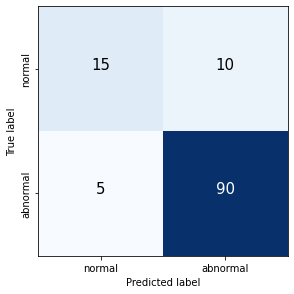

In [29]:
cm = confusion_matrix(valid_abnormal.iloc[:, 1], y_pred_abnormal)
cm_plot_labels = ['normal', 'abnormal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [63]:
y_truth_abnormal = y_valid_abnormal[:, 0]
y_prob_abnormal = Y_pred_abnormal[:, 0]

fpr, tpr, threshold = metrics.roc_curve(y_truth_abnormal, y_prob_abnormal)

auc_abnormal = metrics.auc(fpr, tpr)
print('AUC score:', auc_abnormal)

AUC score: 0.8778947368421053


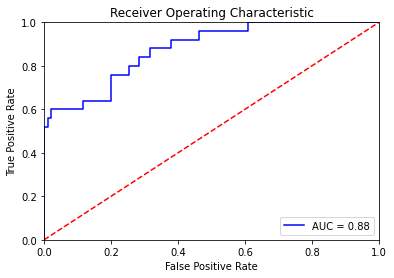

In [62]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
model_abnormal.save_weights('/content/drive/MyDrive/MRNet-v1.0/models/model_abnormal.h5')

In [46]:
train_acl = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/csv/train-acl.csv', header=None)
print(train_acl.shape)
print(np.unique(train_acl.iloc[:,1].values, return_counts=True))
train_acl.head()

(1130, 2)
(array([0, 1]), array([922, 208]))


,0,1
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


In [47]:
valid_acl = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/csv/valid-acl.csv', header=None)
print(valid_acl.shape)
print(np.unique(valid_acl.iloc[:,1].values, return_counts=True))
valid_acl.head()

(120, 2)
(array([0, 1]), array([66, 54]))


,0,1
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0


In [48]:
y_train_acl = train_acl.iloc[:, 1].values
print(y_train_acl.shape)

(1130,)


In [49]:
y_valid_acl = valid_acl.iloc[:, 1]
print(y_valid_acl.shape)

(120,)


In [50]:
y_train_acl = keras.utils.to_categorical(y_train_acl, 2)
y_valid_acl = keras.utils.to_categorical(y_valid_acl, 2)

print(y_train_acl.shape)
print(y_valid_acl.shape)

(1130, 2)
(120, 2)


In [ ]:
del model_acl

In [51]:
model_acl = Sequential()
model_acl.add(Dense(2, input_shape=(1024,), activation='softmax'))

In [52]:
model_acl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 2050      
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [78]:
acl_class_weights = {0: 1.2, 1: 5.4}

In [54]:
model_acl.compile(loss      =   "categorical_crossentropy",
                  optimizer =   "adam",
                  metrics   =   ["accuracy"])

In [55]:
history = model_acl.fit(axial_train_features,
                        y_train_acl,
                        epochs                 =   epochs,
                        # callbacks              =   [my_callbacks],
                        batch_size             =   batch_size,
                        validation_split       =   0.2,
                        class_weight           =   acl_class_weights,
                        use_multiprocessing    =   True,
                        workers                =   4)

Epoch 1/200
57/57 [==============================] - 0s 4ms/step - loss: 1.4188 - accuracy: 0.5332 - val_loss: 0.9916 - val_accuracy: 0.2212
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 1.2866 - accuracy: 0.5852 - val_loss: 0.5832 - val_accuracy: 0.7035
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 1.2306 - accuracy: 0.6383 - val_loss: 0.5556 - val_accuracy: 0.7212
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 1.2424 - accuracy: 0.6604 - val_loss: 0.6062 - val_accuracy: 0.6504
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 1.1964 - accuracy: 0.6659 - val_loss: 0.5634 - val_accuracy: 0.7080
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 1.1877 - accuracy: 0.7080 - val_loss: 0.9699 - val_accuracy: 0.3451
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 1.2287 - accuracy: 0.6604 - val_loss: 0.5571 - val_accuracy: 0.6858
Epoch 8/200
5

In [56]:
score = model_acl.evaluate(axial_valid_features, y_valid_acl, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4318944215774536
Test accuracy: 0.8166666626930237


In [57]:
Y_pred_acl = model_acl.predict(axial_valid_features)
y_pred_acl = np.argmax(Y_pred_acl, axis=1)

In [58]:
print('Classification Report:')
target_names = ['normal', 'acl']
print(classification_report(valid_acl.iloc[:, 1], y_pred_acl, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      normal       0.83      0.83      0.83        66
         acl       0.80      0.80      0.80        54

    accuracy                           0.82       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.82      0.82      0.82       120



Confusion matrix, without normalization


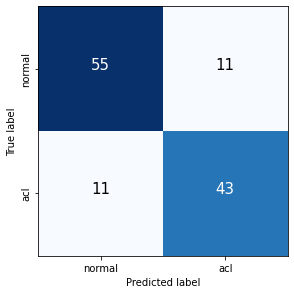

In [59]:
cm2 = confusion_matrix(valid_acl.iloc[:, 1], y_pred_acl)
cm_plot_labels2 = ['normal', 'acl']
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels2, title='')

In [64]:
y_truth_acl = y_valid_acl[:, 0]
y_prob_acl = Y_pred_acl[:, 0]

fpr, tpr, threshold = metrics.roc_curve(y_truth_acl, y_prob_acl)

auc_acl = metrics.auc(fpr, tpr)
print('AUC score:', auc_acl)

AUC score: 0.8765432098765432


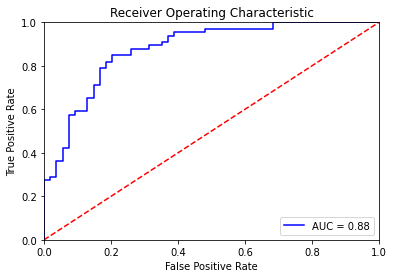

In [65]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_acl)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [66]:
model_acl.save_weights('/content/drive/MyDrive/MRNet-v1.0/models/model_acl.h5')

In [67]:
train_meniscus = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/csv/train-meniscus.csv', header=None)
print(train_meniscus.shape)
print(np.unique(train_meniscus.iloc[:,1].values, return_counts=True))
train_meniscus.head()

(1130, 2)
(array([0, 1]), array([733, 397]))


,0,1
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [75]:
(1130 / (2 * 397)) * 2

2.8463476070528966

In [68]:
valid_meniscus = pd.read_csv('/content/drive/MyDrive/MRNet-v1.0/csv/valid-meniscus.csv', header=None)
print(valid_meniscus.shape)
print(np.unique(valid_meniscus.iloc[:,1].values, return_counts=True))
valid_meniscus.head()

(120, 2)
(array([0, 1]), array([68, 52]))


,0,1
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0


In [69]:
y_train_meniscus = train_meniscus.iloc[:, 1].values
print(y_train_meniscus.shape)

(1130,)


In [70]:
y_valid_meniscus = valid_meniscus.iloc[:, 1]
print(y_valid_meniscus.shape)

(120,)


In [71]:
y_train_meniscus = keras.utils.to_categorical(y_train_meniscus, 2)
y_valid_meniscus = keras.utils.to_categorical(y_valid_meniscus, 2)

print(y_train_meniscus.shape)
print(y_valid_meniscus.shape)

(1130, 2)
(120, 2)


In [102]:
del model_meniscus

In [103]:
model_meniscus = Sequential()
model_meniscus.add(Dense(2, input_shape=(1024,), activation='softmax'))

In [104]:
model_meniscus.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 2050      
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [105]:
# meniscus_class_weights = {0: 1.5, 1: 2.8}
meniscus_class_weights = {0: 0.75, 1: 1.4}

In [106]:
model_meniscus.compile(loss      =   "categorical_crossentropy",
                       optimizer =   "adam",
                       metrics   =   ["accuracy"])

In [107]:
history = model_meniscus.fit(axial_train_features,
                             y_train_meniscus,
                             epochs                 =   epochs,
                             batch_size             =   batch_size,
                             validation_split       =   0.2,
                             shuffle                =   True,
                             class_weight           =   meniscus_class_weights,
                             use_multiprocessing    =   True,
                             workers                =   4)

Epoch 1/200
57/57 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.5697 - val_loss: 0.7147 - val_accuracy: 0.5442
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6394 - val_loss: 0.6040 - val_accuracy: 0.6549
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.6715 - val_loss: 0.8424 - val_accuracy: 0.4867
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.6748 - val_loss: 0.7143 - val_accuracy: 0.5929
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.5748 - accuracy: 0.6858 - val_loss: 0.6838 - val_accuracy: 0.5841
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.5778 - accuracy: 0.6748 - val_loss: 0.5664 - val_accuracy: 0.7168
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.5689 - accuracy: 0.6958 - val_loss: 0.5641 - val_accuracy: 0.7257
Epoch 8/200
5

In [108]:
score = model_meniscus.evaluate(axial_valid_features, y_valid_meniscus, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6264706254005432
Test accuracy: 0.6916666626930237


In [109]:
Y_pred_meniscus = model_meniscus.predict(axial_valid_features)
y_pred_meniscus = np.argmax(Y_pred_meniscus, axis=1)

In [110]:
print('Classification Report:')
target_names = ['normal', 'meniscus']
print(classification_report(valid_meniscus.iloc[:, 1], y_pred_meniscus, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      normal       0.70      0.79      0.74        68
    meniscus       0.67      0.56      0.61        52

    accuracy                           0.69       120
   macro avg       0.69      0.68      0.68       120
weighted avg       0.69      0.69      0.69       120



Confusion matrix, without normalization


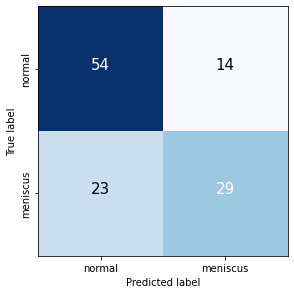

In [111]:
cm3 = confusion_matrix(valid_meniscus.iloc[:, 1], y_pred_meniscus)
cm_plot_labels3 = ['normal', 'meniscus']
plot_confusion_matrix(cm=cm3, classes=cm_plot_labels3, title='')

In [112]:
y_truth_meniscus = y_valid_meniscus[:, 0]
y_prob_meniscus = Y_pred_meniscus[:, 0]

fpr, tpr, threshold = metrics.roc_curve(y_truth_meniscus, y_prob_meniscus)

auc_meniscus = metrics.auc(fpr, tpr)
print('AUC score:', auc_meniscus)

AUC score: 0.7378393665158371


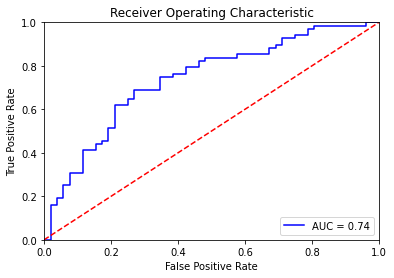

In [113]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_meniscus)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [114]:
model_meniscus.save_weights('/content/drive/MyDrive/MRNet-v1.0/models/model_meniscus.h5')